In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants

from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.neuron_data import NeuronData
import os 

### Load file

In [52]:
neu_path = "/home/INT/losada.c/Documents/session_struct/v4/neurons/2023-03-03_10-59-32_Riesling_v4_e1_r1_mua1_neu.h5"
neu_data = NeuronData.from_python_hdf5(neu_path)

In [87]:
# parameters
time_before=500
select_block=2
start=-200
end=1500
idx_start = time_before + start 
idx_end = time_before+end

### Select relevant trials

In [88]:
# Define target codes 
position_codes= {
    # code: [ML axis], [plot axis]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}

In [89]:
def conv_mean_trials_fr(arr,fs = 1000,w_size=0.1,w_std=0.015):
    # define kernel for convolution

    kernel = firing_rate.define_kernel(
        w_size, w_std, fs=fs
    )
    mean_arr = arr.mean(axis=0)
    conv = np.convolve(mean_arr, kernel, mode="same") * fs
    return conv

In [90]:
# select correct trials, block two, position, and align with target onset 
sp_target_on_all=[]
conv_all=[]
n_trials=[]
for code in position_codes.keys():
    sp_target_on,mask_in = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= int(code),
        event ="target_on",
        time_before = time_before,
        correct_trials= True,
    )

    sp_target_on_all.append(sp_target_on[:,idx_start:idx_end])
    conv_all.append(conv_mean_trials_fr(arr=sp_target_on,fs = 1000,w_size=0.1,w_std=0.015)[idx_start:idx_end])
    n_trials.append(mask_in.sum())


### Select trials by target code

## Plot rasters for each neuron for each target

/tmp/ipykernel_48958/924580397.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))


Text(0.5, 1.05, '2023-03-03_10-59-32: v4 mua 1 ')

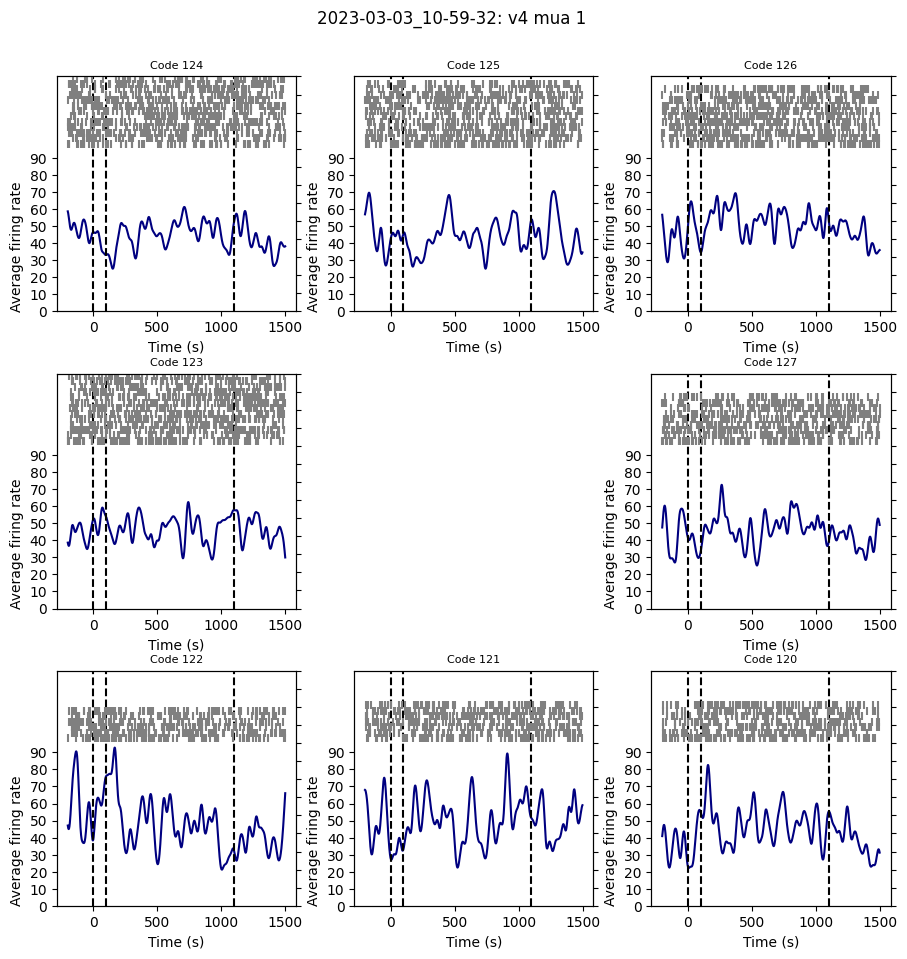

In [94]:
fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) 
conv_max = np.max(conv_all)
max_num_trials = max(n_trials)
for code,sp_target_on,conv in zip(position_codes.keys(),sp_target_on_all,conv_all):

    axis = position_codes[code][1]
    ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))    
    time = np.arange(0,len(conv))+ start
    ax2 = ax.twinx()
    # ----- plot conv----------
    ax.plot(time, conv, color="navy")
    # ----- plot spikes----------
    rows, cols = np.where(sp_target_on >= 1)
    cols = cols +start
    rows = rows + rows * 2
    ax2.scatter(cols, rows, marker="|", alpha=1, color="grey")
    ax.set_title("Code %s" % (code), fontsize=8)
    
    ax.set_ylim(0, conv_max + max_num_trials * 3)
    ax.set_yticks(np.arange(0, conv_max, 10))
    ax2.set_ylim(-conv_max, max_num_trials)
    ax2.set_yticks(np.arange(-conv_max, max_num_trials * 3, 10))

    plt.setp(ax2.get_yticklabels(), visible=False)
    
    ax.set_ylabel(ylabel="Average firing rate",fontsize=10,loc="bottom")
    ax.set_xlabel(xlabel="Time (s)",fontsize=10)
    ax.vlines(
            [0,100,1100],
            0,
            conv_max + max_num_trials * 3,
            color="k",
            linestyles="dashed",
            )  # target_on

fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
fig.suptitle("%s: %s %s %d " % (neu_data.date_time, neu_data.area, neu_data.cluster_group, neu_data.cluster_number), x=0.5, y=1.05,fontsize=12)